In [ ]:
import torch
import torch.nn.functional as F
!pip install torch_geometric
# !pip install torch-sparse
# !pip install torch-scatter
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import degree, add_self_loops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 10.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=a489c6e3a8dbb44f086b25865603fc4eb41b36ab54063254d98c499c8620e13c
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric
Found existing installation: torch-geometric 2.3.0
Uninstalling torch-geometric-2.3.0:
  Successfully uninstalled torch-geometric-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 8.3 MB/s eta 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make Adjacency Matrix

***ORI KA VERSION***

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from networkx.linalg.graphmatrix import adjacency_matrix
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.data import DataLoader, Dataset, Data
import random
# Load the dataset from CSV file
# random.seed(0)
# torch.manual_seed(0)

# k is the number of graphs for one-category 
num_graph=60
edge_index = []
x = []
data_list=[]
#LOOP FOR MU+

for i in range(0,num_graph):
    df = pd.read_csv(f'/content/drive/MyDrive/ROOT Data/event-muplus{i}.csv')
    print(f'graph going on is for mu+ {i}')
    # Split the dataset by layer number using a for loop
    layer_data = []
    for layer_num in range(1, 48): # there are only 47 layers
        layer_df = df.loc[df['Layer'] == layer_num] # filter rows by layer number
        layer_data.append(layer_df)
        #print(layer_data)

    #Connect nodes from layer 1 with layer 2 and so on.... using Euclidean distance

    # Calculate Euclidean distance between every pair of nodes in the two layers
    distances = []

    # Iterate over all pairs of layers
    distances = []
    for i in range(1, 48):
        for j in range(i+1, 48):
            layer1 = layer_data[i-1]
            layer2 = layer_data[j-1]
            for k in range(len(layer1)):
                for l in range(len(layer2)):
                    dist = ((layer1.iloc[k]['X'] - layer2.iloc[l]['X']) ** 2 + (layer1.iloc[k]['Y'] - layer2.iloc[l]['Y']) ** 2) ** 0.5
                    distances.append(dist)


    # Set the threshold as the median  of distances
    threshold = np.median(distances)

    # Create a graph using NetworkX
    G = nx.Graph()

    # Add nodes to the graph for each layer separately
    a=0
    ab=[]
    for layer_num, layer_df in enumerate(layer_data, 1):
        for i, row in layer_df.iterrows():
            node_name = f'Layer{layer_num}-node{i}'
            adc_value = row['ADC']
            layer_value = row['Layer']
            G.add_node(node_name, x=row['X'], y=row['Y'], adc=adc_value, layer=layer_value)
            a = a + 1
      
    node_list = list(G.nodes())
    #print(node_list)


    # Connect nodes from layer 1 with layer 2 based on Euclidean distance
    abc=[]
    b=0
    for i in range(1,48):
        for j in range(i+1, 48):
            layer1 = layer_data[i-1]
            layer2 = layer_data[j-1]
            for k, row1 in layer1.iterrows():
                for l, row2 in layer2.iterrows():
                    dist = ((row1['X'] - row2['X']) ** 2 + (row1['Y'] - row2['Y']) ** 2) ** 0.5
                    if dist <= threshold:
                        node1 = f'layer{i+1}-node{k}'
                        node2 = f'layer{j+1}-node{l}'
                        G.add_edge(node1, node2)
             #adc_value = (adc_value[i] + adc_value[j])/2
            b=b+1
            abc.append((node1, node2))
            #print(f'layer1-node{i}', f'layer2-node{j}')
            #df1 = pd.DataFrame(abc)
            #ax = df1.plot.scatter(x=10,y= 10,c='Black')

    # print(a,b)
    # print(len(abc))

    # Make adjacency matrix and convert to tensor

    vertices = set()
    for edge in abc:
      vertices.update(edge)

    # Create a dictionary to map each vertex to a unique index
    index_map = {vertex: i for i, vertex in enumerate(vertices)}

    # Create the adjacency matrix
    n = len(vertices)
    adj_matrix = [[0] * n for _ in range(n)]
    for edge in abc:
      i, j = index_map[edge[0]], index_map[edge[1]]
      adj_matrix[i][j] = 1
      adj_matrix[j][i] = 1

    # Print the adjacency matrix
    #for row in adj_matrix:
      # print(row)
      
    #create an empty list for all matrices
    

    arr = np.array(adj_matrix)

    rows, cols = np.where(arr == 1)
    adj_tensor = torch.tensor([rows, cols], dtype=torch.long)

    edge_index.append(adj_tensor)

    # Make Feature matrix and convert to tensor

    # Extract the two feature columns as a 2D numpy array
    features = df[['Layer', 'ADC']].to_numpy()
    # Convert the numpy array to a PyTorch tensor
    feature_matrix = torch.tensor(features, dtype=torch.float)
    x.append(feature_matrix)

for i in range(0,num_graph):
  data_list.append(Data(x=x[i], edge_index=edge_index[i], y=torch.tensor([1], dtype=torch.long)))


edge_index = []
x = []

# loop for mu-

for i in range(0,num_graph):
    df = pd.read_csv(f'/content/drive/MyDrive/ROOT Data/event-muminus{i}.csv')
    print(f'graph going on is for mu- {i}')
    # Split the dataset by layer number using a for loop
    layer_data = []
    for layer_num in range(1, 48): # there are only 47 layers
        layer_df = df.loc[df['Layer'] == layer_num] # filter rows by layer number
        layer_data.append(layer_df)
        #print(layer_data)

    #Connect nodes from layer 1 with layer 2 and so on.... using Euclidean distance

    # Calculate Euclidean distance between every pair of nodes in the two layers
    distances = []

    # Iterate over all pairs of layers
    distances = []
    for i in range(1, 48):
        for j in range(i+1, 48):
            layer1 = layer_data[i-1]
            layer2 = layer_data[j-1]
            for k in range(len(layer1)):
                for l in range(len(layer2)):
                    dist = ((layer1.iloc[k]['X'] - layer2.iloc[l]['X']) ** 2 + (layer1.iloc[k]['Y'] - layer2.iloc[l]['Y']) ** 2) ** 0.5
                    distances.append(dist)


    # Set the threshold as the median  of distances
    threshold = np.median(distances)

    # Create a graph using NetworkX
    G = nx.Graph()

    # Add nodes to the graph for each layer separately
    a=0
    ab=[]
    for layer_num, layer_df in enumerate(layer_data, 1):
        for i, row in layer_df.iterrows():
            node_name = f'Layer{layer_num}-node{i}'
            adc_value = row['ADC']
            layer_value = row['Layer']
            G.add_node(node_name, x=row['X'], y=row['Y'], adc=adc_value, layer=layer_value)
            a = a + 1
      
    node_list = list(G.nodes())
    #print(node_list)


    # Connect nodes from layer 1 with layer 2 based on Euclidean distance
    abc=[]
    b=0
    for i in range(1,48):
        for j in range(i+1, 48):
            layer1 = layer_data[i-1]
            layer2 = layer_data[j-1]
            for k, row1 in layer1.iterrows():
                for l, row2 in layer2.iterrows():
                    dist = ((row1['X'] - row2['X']) ** 2 + (row1['Y'] - row2['Y']) ** 2) ** 0.5
                    if dist <= threshold:
                        node1 = f'layer{i+1}-node{k}'
                        node2 = f'layer{j+1}-node{l}'
                        G.add_edge(node1, node2)
             #adc_value = (adc_value[i] + adc_value[j])/2
            b=b+1
            abc.append((node1, node2))
            #print(f'layer1-node{i}', f'layer2-node{j}')
            #df1 = pd.DataFrame(abc)
            #ax = df1.plot.scatter(x=10,y= 10,c='Black')

    # print(a,b)
    # print(len(abc))

    # Make adjacency matrix and convert to tensor

    vertices = set()
    for edge in abc:
      vertices.update(edge)

    # Create a dictionary to map each vertex to a unique index
    index_map = {vertex: i for i, vertex in enumerate(vertices)}

    # Create the adjacency matrix
    n = len(vertices)
    adj_matrix = [[0] * n for _ in range(n)]
    for edge in abc:
      i, j = index_map[edge[0]], index_map[edge[1]]
      adj_matrix[i][j] = 1
      adj_matrix[j][i] = 1

    # Print the adjacency matrix
    #for row in adj_matrix:
      # print(row)
      
    #create an empty list for all matrices
    

    arr = np.array(adj_matrix)

    rows, cols = np.where(arr == 1)
    adj_tensor = torch.tensor([rows, cols], dtype=torch.long)

    edge_index.append(adj_tensor)

    # Make Feature matrix and convert to tensor

    # Extract the two feature columns as a 2D numpy array
    features = df[['Layer', 'ADC']].to_numpy()
    # Convert the numpy array to a PyTorch tensor
    feature_matrix = torch.tensor(features, dtype=torch.float)
    x.append(feature_matrix)

for i in range(0,num_graph):
  data_list.append(Data(x=x[i], edge_index=edge_index[i], y=torch.tensor([0], dtype=torch.long)))


for i in range(0,2*num_graph):
  print(data_list[i],"The target label is->",data_list[i]['y'])


graph going on is for mu+ 0
graph going on is for mu+ 1
graph going on is for mu+ 2
graph going on is for mu+ 3
graph going on is for mu+ 4
graph going on is for mu+ 5
graph going on is for mu+ 6
graph going on is for mu+ 7
graph going on is for mu+ 8
graph going on is for mu+ 9
graph going on is for mu+ 10
graph going on is for mu+ 11
graph going on is for mu+ 12
graph going on is for mu+ 13
graph going on is for mu+ 14
graph going on is for mu+ 15
graph going on is for mu+ 16
graph going on is for mu+ 17
graph going on is for mu+ 18
graph going on is for mu+ 19
graph going on is for mu+ 20
graph going on is for mu+ 21
graph going on is for mu+ 22
graph going on is for mu+ 23
graph going on is for mu+ 24
graph going on is for mu+ 25
graph going on is for mu+ 26
graph going on is for mu+ 27
graph going on is for mu+ 28
graph going on is for mu+ 29
graph going on is for mu+ 30
graph going on is for mu+ 31
graph going on is for mu+ 32
graph going on is for mu+ 33
graph going on is for mu

Testing and training

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
stop1 48
stop2 108
Training element 0 is  Data(x=[85, 2], edge_index=[2, 2022], y=[1]) tensor([1])
Training element 1 is  Data(x=[111, 2], edge_index=[2, 2046], y=[1]) tensor([1])
Training element 2 is  Data(x=[111, 2], edge_index=[2, 2144], y=[1]) tensor([1])
Training element 3 is  Data(x=[145, 2], edge_index=[2, 2142], y=[1]) tensor([1])
Training element 4 is  Data(x=[102, 2], edge_index=[2, 2058], y=[1]) tensor([1])
Training element 5 is  Data(x=[164, 2], edge_index=[2, 2118], y=[1]) tensor([1])
Training element 6 is  Data(x=[104, 2], edge_index=[2, 2122], y=[1]) tensor([1])
Training element 7 is  Data(x=[128, 2], edge_index=[2, 2054], y=[1]) tensor([1])
Training element 8 is  Data(x=[165, 2], edge_index=[2, 1790], y=[1]) tensor([1])
Training element 9 is  Data(x=[111, 2], edge_index=[2, 2162], y=[1]) tensor([1])
Training element 10 is  Data(x=[152, 2], edge_index=[2, 2092], y=[1]) ten

/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 0.8842456936836243
Accuracy: 58.33%
Epoch 2, Loss: 1.1998448371887207
Accuracy: 54.17%
Epoch 3, Loss: 1.1850355863571167
Accuracy: 54.17%
Epoch 4, Loss: 1.0701930522918701
Accuracy: 54.17%
Epoch 5, Loss: 0.8938696384429932
Accuracy: 54.17%
Epoch 6, Loss: 0.755525529384613
Accuracy: 58.33%
Epoch 7, Loss: 0.6808944940567017
Accuracy: 58.33%
Epoch 8, Loss: 0.6298049688339233
Accuracy: 58.33%
Epoch 9, Loss: 0.6008515357971191
Accuracy: 58.33%
Epoch 10, Loss: 0.5733214020729065
Accuracy: 58.33%
Epoch 11, Loss: 0.5364552140235901
Accuracy: 54.17%
Epoch 12, Loss: 0.5061410069465637
Accuracy: 54.17%
Epoch 13, Loss: 0.45478788018226624
Accuracy: 58.33%
Epoch 14, Loss: 0.42987510561943054
Accuracy: 58.33%
Epoch 15, Loss: 0.413291871547699
Accuracy: 58.33%
Epoch 16, Loss: 0.38514629006385803
Accuracy: 58.33%
Epoch 17, Loss: 0.3778949975967407
Accuracy: 58.33%
Epoch 18, Loss: 0.3554839789867401
Accuracy: 58.33%
Epoch 19, Loss: 0.336701363325119
Accuracy: 58.33%
Epoch 20, Loss: 0.314

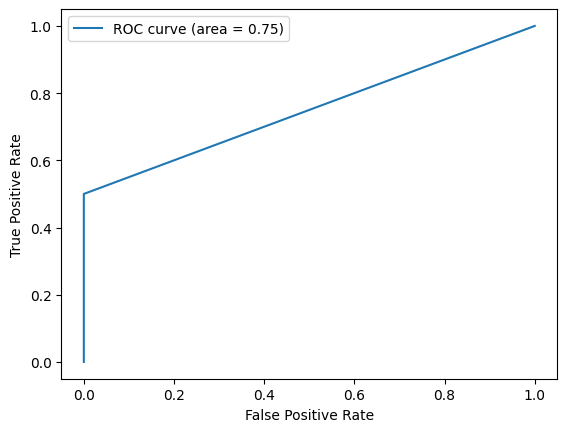

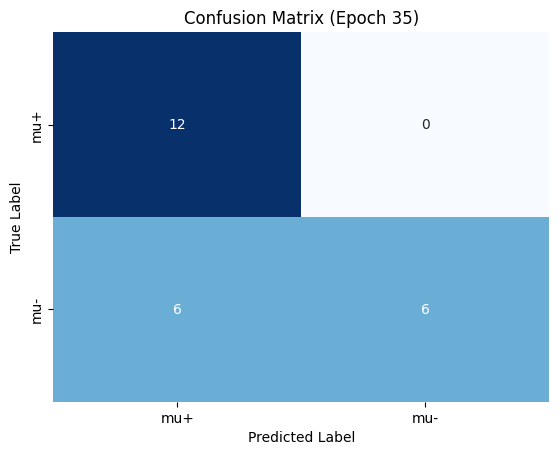

Precision: 0.83
Recall: 0.75
F1 Score: 0.73


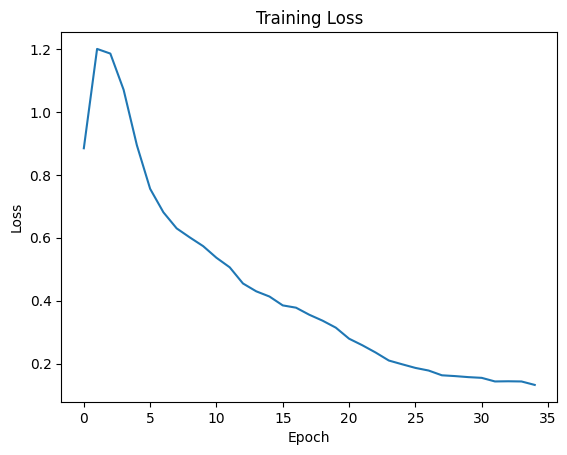

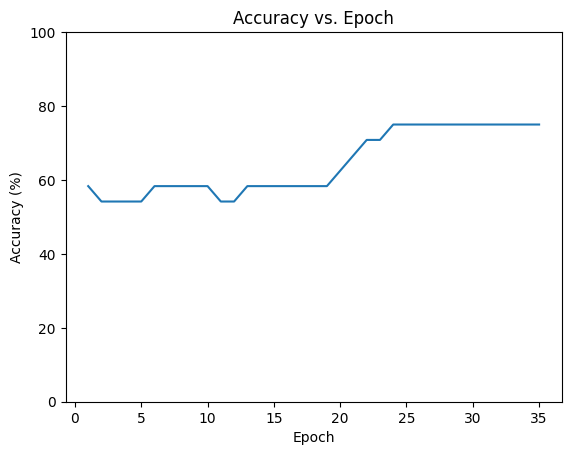

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.data import DataLoader, Dataset, Data
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


# Define lists to store evaluation results
all_preds = []
all_labels = []
all_losses = []
accuracies = []
classes =['mu+','mu-']
!pip install optuna
torch.manual_seed(69)

stop1=int((4*num_graph)/5)
stop2=int(num_graph+(4*num_graph)/5)
print("stop1",stop1)
print("stop2",stop2)

train_data = data_list[:stop1]
for i in range(num_graph,stop2):
  train_data.append(data_list[i])

test_data = data_list[stop1:num_graph]
for i in range(stop2,2*num_graph):
  test_data.append(data_list[i])

for i in range(0,int((8*num_graph)/5)):
  print("Training element",i,"is ",train_data[i],train_data[i]['y'])
for i in range(0,int((2*num_graph)/5)):
  print("Testing element",i,"is ",test_data[i],test_data[i]['y'])

# Define the GCN model (working one original)

class Net(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = Linear(hidden_channels, hidden_channels)
        self.fc2 = Linear(hidden_channels, num_classes)
        self.reg_lambda = reg_lambda
        
    def forward(self, x, edge_index, batch):
        # Perform message passing through two GCN layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Aggregate the node representations into a single graph representation
        x = global_add_pool(x, batch)
        
        # Apply two fully-connected layers to obtain the final output
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

reg_lambda = 0.0001


# class Net(torch.nn.Module):
#     def __init__(self, num_features, hidden_channels, num_classes):
#         super(Net, self).__init__()
#         self.conv1 = GCNConv(num_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, hidden_channels)
#         self.conv4 = GCNConv(hidden_channels, hidden_channels)
#         self.conv5 = GCNConv(hidden_channels, hidden_channels)
#         self.fc1 = Linear(hidden_channels, hidden_channels)
#         self.fc2 = Linear(hidden_channels, num_classes)

#     def forward(self, x, edge_index, batch):
#         # Perform message passing through five GCN layers
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.relu(self.conv2(x, edge_index))
#         x = F.relu(self.conv3(x, edge_index))
#         x = F.relu(self.conv4(x, edge_index))
#         x = F.relu(self.conv5(x, edge_index))

#         # Aggregate the node representations into a single graph representation
#         x = global_add_pool(x, batch)
        
#         # Apply two fully-connected layers to obtain the final output
#         x = self.fc2(x)

#         return F.log_softmax(x, dim=1)


# Define the training parameters
num_features = 2
hidden_channels = 16
num_classes = 2
lr = 0.00001
epochs = 35

# Create the GCN model and optimizer
model = Net(num_features, hidden_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create a data loader for the dataset
batch_size = 1


# Create data loaders for the training and testing datasets
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=False)

# Train the model
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.nll_loss(out, batch.y)
        # Add L1 regularization
        l1_reg = 0
        for param in model.parameters():
            l1_reg += torch.abs(param).sum()
        loss += reg_lambda * l1_reg
        loss.backward()
        optimizer.step()
    print('Epoch {}, Loss: {}'.format(epoch+1, loss.item()))

    # Test the model on the test dataset
    model.eval()
    correct = 0
    total = 0
    preds = []
    labels = []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            preds.extend(pred.cpu().numpy().tolist())
            labels.extend(batch.y.cpu().numpy().tolist())
            correct += pred.eq(batch.y).sum().item()
            total += batch.y.size(0)
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    print('Accuracy: {:.2f}%'.format(accuracy))

    # Calculate evaluation metrics
    # all_preds.extend(preds)
    # all_labels.extend(labels)
    all_losses.append(loss.item())

# Calculate AUC and ROC
auc = roc_auc_score(labels, preds)
fpr, tpr, _ = roc_curve(labels, preds)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Convert predictions and labels to numpy arrays
preds = np.array(preds)
labels = np.array(labels)

# Define class labels
class_labels = ["mu+", "mu-"]

# Calculate confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix (Epoch {})'.format(epochs))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.show()

# Convert predictions and labels to numpy arrays
preds = np.array(preds)
labels = np.array(labels)

# Visualize Loss
plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Calculate Precision, Recall, and F1 Score
precision = precision_score(labels, preds, average='macro')
recall = recall_score(labels, preds, average='macro')
f1 = f1_score(labels, preds, average='macro')
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 Score: {:.2f}'.format(f1))

plt.show()


# Plot accuracy vs. epoch curve

plt.figure()
plt.plot(range(1, epochs+1), accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epoch')
plt.ylim([0, 100])  # set y-axis limits to start from 0
plt.show()

# import optuna

# def objective(trial):
#     # Define the hyperparameters to optimize
#     num_features = 2
#     hidden_channels = trial.suggest_int('hidden_channels', 16, 128)
#     lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
#     epochs = 50

#     # Create the GCN model and optimizer
#     model = Net(num_features, hidden_channels, num_classes)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     # Train the model
#     for epoch in range(epochs):
#         model.train()
#         for batch in train_loader:
#             optimizer.zero_grad()
#             out = model(batch.x, batch.edge_index, batch.batch)
#             loss = F.nll_loss(out, batch.y)
#             loss.backward()
#             optimizer.step()

#     # Test the model on the test dataset
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for batch in test_loader:
#             out = model(batch.x, batch.edge_index, batch.batch)
#             pred = out.argmax(dim=1)
#             correct += pred.eq(batch.y).sum().item()
#             total += batch.y.size(0)

#     accuracy = 100 * correct / total
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print('Number of finished trials:', len(study.trials))
# print('Best trial:')
# trial = study.best_trial
# print('  Value: {:.2f}'.format(trial.value))
# print('  Params: ')
# for key, value in trial.params.items():
#     print('    {}: {}'.format(key, value))



In [ ]:
# NEW - 

# import torch
# from torch.nn import Linear, Dropout
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, global_add_pool
# from torch_geometric.data import DataLoader, Dataset, Data

# torch.manual_seed(69)

# stop1=int((4*num_graph)/5)
# stop2=int(num_graph+(4*num_graph)/5)
# print("stop1",stop1)
# print("stop2",stop2)

# train_data = data_list[:stop1]
# for i in range(num_graph,stop2):
#   train_data.append(data_list[i])

# test_data = data_list[stop1:num_graph]
# for i in range(stop2,2*num_graph):
#   test_data.append(data_list[i])

# for i in range(0,int((8*num_graph)/5)):
#   print("Training element",i,"is ",train_data[i],train_data[i]['y'])
# for i in range(0,int((2*num_graph)/5)):
#   print("Testing element",i,"is ",test_data[i],test_data[i]['y'])

# # Define the GCN model
# class Net(torch.nn.Module):
#     def __init__(self, num_features, hidden_channels, num_classes):
#         super(Net, self).__init__()
#         self.conv1 = GCNConv(num_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, hidden_channels)
#         self.fc1 = Linear(hidden_channels, hidden_channels)
#         self.fc2 = Linear(hidden_channels, num_classes)
#         self.dropout = Dropout(p=0.5)

#     def forward(self, x, edge_index, batch):
#         # Perform message passing through three GCN layers
#         x = F.relu(self.conv1(x, edge_index))
#         x = F.relu(self.conv2(x, edge_index))
#         x = F.relu(self.conv3(x, edge_index))

#         # Aggregate the node representations into a single graph representation
#         x = global_add_pool(x, batch)

#         # Apply two fully-connected layers with dropout to obtain the final output
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)

#         return F.log_softmax(x, dim=1)

# # Define the training parameters
# num_features = 2
# hidden_channels = 64
# num_classes = 2
# lr = 0.00001
# epochs = 100

# # Create the GCN model and optimizer
# model = Net(num_features, hidden_channels, num_classes)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# # Create data loaders for the training and testing datasets
# batch_size = 16
# train_loader = DataLoader(train_data, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

# # Train the model
# for epoch in range(epochs):
#     model.train()
#     for batch in train_loader:
#         optimizer.zero_grad()
#         out = model(batch.x, batch.edge_index, batch.batch)
#         loss = F.nll_loss(out, batch.y)
#         loss.backward()
#         optimizer.step()
#     print('Epoch {}, Loss: {}'.format(epoch+1, loss.item()))

# # Test the model on the test dataset
# model.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for batch in test_loader:
#         out = model(batch.x, batch.edge_index, batch.batch)
#         # print("output pred is",out)
#         pred = out.argmax(dim=1)
#         correct += pred.eq(batch.y).sum().item()
#         total += batch.y.size(0)
#         print('Actual label was->',batch.y,'Predicted output:', pred)
# accuracy = 100 * correct / total
# print('Accuracy: {:.2f}%'.format(accuracy))

***Testing for 61st graph*** 

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from networkx.linalg.graphmatrix import adjacency_matrix


# Load the dataset from CSV file

for i in range(60,61):
    df = pd.read_csv(f'/content/event-muplus{i}.csv')
    # Split the dataset by layer number using a for loop
    layer_data = []
    for layer_num in range(1, 48): # there are only 47 layers
        layer_df = df.loc[df['Layer'] == layer_num] # filter rows by layer number
        layer_data.append(layer_df)
        #print(layer_data)

    #Connect nodes from layer 1 with layer 2 and so on.... using Euclidean distance

    # Calculate Euclidean distance between every pair of nodes in the two layers
    distances = []

    # Iterate over all pairs of layers
    distances = []
    for i in range(1, 48):
        for j in range(i+1, 48):
            layer1 = layer_data[i-1]
            layer2 = layer_data[j-1]
            for k in range(len(layer1)):
                for l in range(len(layer2)):
                    dist = ((layer1.iloc[k]['X'] - layer2.iloc[l]['X']) ** 2 + (layer1.iloc[k]['Y'] - layer2.iloc[l]['Y']) ** 2) ** 0.5
                    distances.append(dist)


    # Set the threshold as the median  of distances
    threshold = np.median(distances)

    # Create a graph using NetworkX
    G = nx.Graph()

    # Add nodes to the graph for each layer separately
    a=0
    ab=[]
    for layer_num, layer_df in enumerate(layer_data, 1):
        for i, row in layer_df.iterrows():
            node_name = f'Layer{layer_num}-node{i}'
            adc_value = row['ADC']
            layer_value = row['Layer']
            G.add_node(node_name, x=row['X'], y=row['Y'], adc=adc_value, layer=layer_value)
            a = a + 1
      
    node_list = list(G.nodes())
    #print(node_list)


    # Connect nodes from layer 1 with layer 2 based on Euclidean distance
    abc=[]
    b=0
    for i in range(1,48):
        for j in range(i+1, 48):
            layer1 = layer_data[i-1]
            layer2 = layer_data[j-1]
            for k, row1 in layer1.iterrows():
                for l, row2 in layer2.iterrows():
                    dist = ((row1['X'] - row2['X']) ** 2 + (row1['Y'] - row2['Y']) ** 2) ** 0.5
                    if dist <= threshold:
                        node1 = f'layer{i+1}-node{k}'
                        node2 = f'layer{j+1}-node{l}'
                        G.add_edge(node1, node2)
             #adc_value = (adc_value[i] + adc_value[j])/2
            b=b+1
            abc.append((node1, node2))
            #print(f'layer1-node{i}', f'layer2-node{j}')
            #df1 = pd.DataFrame(abc)
            #ax = df1.plot.scatter(x=10,y= 10,c='Black')

    print(a,b)
    print(len(abc))

    # Make adjacency matrix and convert to tensor

    vertices = set()
    for edge in abc:
      vertices.update(edge)

    # Create a dictionary to map each vertex to a unique index
    index_map = {vertex: i for i, vertex in enumerate(vertices)}

    # Create the adjacency matrix
    n = len(vertices)
    adj_matrix = [[0] * n for _ in range(n)]
    for edge in abc:
      i, j = index_map[edge[0]], index_map[edge[1]]
      adj_matrix[i][j] = 1
      adj_matrix[j][i] = 1

    # Print the adjacency matrix
    #for row in adj_matrix:
      # print(row)
      
    #create an empty list for all matrices
    edge_index = []

    arr = np.array(adj_matrix)

    rows, cols = np.where(arr == 1)
    adj_tensor = torch.tensor([rows, cols], dtype=torch.long)

    edge_index.append(adj_tensor)

    # Make Feature matrix and convert to tensor

    x = []
    # Extract the two feature columns as a 2D numpy array
    features = df[['Layer', 'ADC']].to_numpy()
    # Convert the numpy array to a PyTorch tensor
    feature_matrix = torch.tensor(features, dtype=torch.float)
    x.append(feature_matrix)

validation_edge_index=edge_index
validation_feature_matrix=feature_matrix
# print(feature_matrix)
# print(edge_index)

FileNotFoundError: ignored

In [ ]:
#Validation for 61st graph

v_data=Data(x=validation_feature_matrix, edge_index=validation_edge_index, y=torch.tensor([1], dtype=torch.long))
out = model(batch.x, batch.edge_index, batch.batch)
pred = out.argmax(dim=1)
print("prediction is",pred)


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.data import DataLoader, Dataset, Data
import random

# Define the GCN model
class Net(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # Perform message passing through two GCN layers
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Aggregate the node representations into a single graph representation
        x = global_add_pool(x, batch)
        
        # Apply a fully-connected layer to obtain the final output
        x = self.fc(x)

        return F.log_softmax(x, dim=1)


# Create a list of tensors and wrap it in the custom dataset class
# x1 = torch.tensor([[1, 2], [3, 4], [5, 6]], dtype=torch.float)  # Reshape to [num_nodes, num_node_features]
# x2 = torch.tensor([[7, 8], [9, 10], [11, 12], [13, 14], [15, 16]], dtype=torch.float)  
# # Edge index for graph 1
# edge_index1 = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)

# # Edge index for graph 2
# edge_index2 = torch.tensor([[0, 1, 1, 2, 2, 3, 3, 4], [1, 0, 2, 1, 3, 2, 4, 3]], dtype=torch.long)
# y1 = torch.tensor([0], dtype=torch.long)
# y2 = torch.tensor([1], dtype=torch.long)
# data_list = [
#     Data(x=x1, edge_index=edge_index1, y=y1),
#     Data(x=x2, edge_index=edge_index2, y=y2)
# ]
# for i in data:
#   data_list.append(Data(x=mayur_input_features[i]_,edge_index=edge_index[i],y=1/0))

# Define the training parameters
num_features = 2
hidden_channels = 16
num_classes = 2
lr = 0.01
epochs = 10

# Create the GCN model and optimizer
model = Net(num_features, hidden_channels, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Create a data loader for the dataset
batch_size = 1
random.shuffle(data_list)

# Define the split index
split_idx = int(0.8 * len(data_list))

# Split the data into training and testing datasets
train_data = data_list[:split_idx]
test_data = data_list[split_idx:]

# Create data loaders for the training and testing datasets
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Train the model
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = F.nll_loss(out, batch.y)
        loss.backward()
        optimizer.step()
    print('Epoch {}, Loss: {}'.format(epoch+1, loss.item()))

# Test the model on the test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        out = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        total += batch.y.size(0)
        print('Actual label was->',batch.y,'Predicted output:', pred)
accuracy = 100 * correct / total
print('Accuracy: {:.2f}%'.format(accuracy))
